# Fourier Transform using neural networks V2

-   First we generated a dataset of 2500 input functions of various types (2nd cell)
-   $80:10:10$ split of train-validation-test data
-   Every function is defined on the interval $(-1, 1)$. Number of points chosen $N = 256, 512$
-   The following hyperparamters are chosen
    - N = 256, 512
    - Layers = 2, 3, 4, 5
    - Activation functions = ReLU, Leaky ReLU, Sigmoid, Tanh, None
-   Uses coefficient of determination (R2) for computing validation and test loss, better for comparing functions. Training is still done on MSE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, chebyt, jv, hermite, eval_laguerre
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import sys
import time
import os
from sklearn.metrics import r2_score

In [2]:
funtion_types = [
    "fourier",          # sum of sinusoids
    "poly",             # standard polynomial
    "gaussian",         # single Gaussian
    "gaussian_mixture", # sum of Gaussians
    "damped_sine",      # exponentially damped sinusoid
    "exp_decay",        # exponential decay
    "piecewise",        # piecewise linear/quadratic
    "trig_combo",       # combination of sin and cos
    "legendre",         # Legendre polynomials
    "chebyshev",        # Chebyshev polynomials (1st kind)
    "bessel",           # Bessel function of first kind
    "hermite",          # Hermite polynomials
    "laguerre",         # Laguerre polynomials
    "windowed_sine",    # sinusoid multiplied by Gaussian
    "rect_pulse",       # rectangular pulse
    "sawtooth",         # sawtooth wave
    "triangle",         # triangle wave
    "modulated",        # product of sinusoids (beats)
    "chirp",            # frequency-increasing sinusoid
    "spikes",           # sparse impulses
    "wavelet"           # Mexican hat wavelet
]

In [3]:
def make_function(x, kind="random", max_freq=10):
    """
    Generate a diverse set of functions for Fourier testing.

    Parameters:
        x        : array of input points
        kind     : type of function to generate; if 'random', one is picked randomly
        max_freq : maximum frequency for Fourier-type functions

    Returns:
        f        : array of function values
    """
    
    if kind == "random":
        kind = np.random.choice(function_types)
    
    # ----------------- Standard types -----------------
    if kind == "fourier":
        coeffs = np.random.randn(max_freq)
        f = np.zeros_like(x, dtype=float)
        for n, a in enumerate(coeffs, start=1):
            f += a * np.sin(np.pi * n * x)
        return f

    elif kind == "poly":
        coeffs = np.random.randn(5)
        return sum(c * x**i for i, c in enumerate(coeffs))

    elif kind == "gaussian":
        mu, sigma = np.random.uniform(-0.5, 0.5), np.random.uniform(0.05, 0.5)
        return np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

    elif kind == "gaussian_mixture":
        num_gaussians = np.random.randint(2, 4)
        f = np.zeros_like(x)
        for _ in range(num_gaussians):
            mu, sigma, amp = np.random.uniform(-0.5,0.5), np.random.uniform(0.05,0.3), np.random.uniform(0.5,2.0)
            f += amp * np.exp(-((x - mu)**2) / (2 * sigma**2))
        return f

    elif kind == "damped_sine":
        freq = np.random.uniform(1, max_freq)
        decay = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        return np.exp(-decay * np.abs(x)) * np.sin(2 * np.pi * freq * x + phase)

    elif kind == "exp_decay":
        lam = np.random.uniform(0.5, 2.0)
        return np.exp(-lam * np.abs(x))

    elif kind == "piecewise":
        split = np.random.uniform(x[0], x[-1])
        return np.piecewise(x, [x < split, x >= split],
                            [lambda t: t**2, lambda t: -t + split])

    elif kind == "trig_combo":
        f = np.zeros_like(x)
        num_terms = np.random.randint(2, 5)
        for _ in range(num_terms):
            amp = np.random.uniform(0.5, 2.0)
            freq = np.random.randint(1, max_freq)
            phase = np.random.uniform(0, 2*np.pi)
            f += amp * (np.sin(2*np.pi*freq*x + phase) + np.cos(2*np.pi*freq*x + phase))
        return f

    # ----------------- Special polynomials -----------------
    elif kind == "legendre":
        deg = np.random.randint(1, 6)
        P = legendre(deg)
        return P(x)

    elif kind == "chebyshev":
        deg = np.random.randint(1, 6)
        T = chebyt(deg)
        return T(x)

    elif kind == "bessel":
        order = np.random.randint(0, 6)
        k = np.random.uniform(1, 10)
        return jv(order, k * x)

    elif kind == "hermite":
        deg = np.random.randint(1,5)
        H = hermite(deg)
        return H(x)

    elif kind == "laguerre":
        deg = np.random.randint(1,5)
        return eval_laguerre(deg, np.abs(x))  # Laguerre defined on [0,∞)

    # ----------------- Windowed / localized functions -----------------
    elif kind == "windowed_sine":
        freq = np.random.uniform(1, max_freq)
        alpha = np.random.uniform(1,5)
        return np.sin(2*np.pi*freq*x) * np.exp(-alpha*x**2)

    elif kind == "rect_pulse":
        start, end = np.random.uniform(-0.5, 0), np.random.uniform(0,0.5)
        return np.where((x>=start) & (x<=end), 1.0, 0.0)

    elif kind == "sawtooth":
        return 2*(x - np.floor(x + 0.5))  # normalized sawtooth

    elif kind == "triangle":
        return 2*np.abs(2*(x - np.floor(x + 0.5))) - 1

    elif kind == "modulated":
        f1 = np.sin(5*np.pi*x)
        f2 = np.cos(2*np.pi*x)
        return f1*f2

    elif kind == "chirp":
        return np.sin(2*np.pi*(x + x**2))

    elif kind == "spikes":
        f = np.zeros_like(x)
        num_spikes = np.random.randint(3,8)
        indices = np.random.choice(len(x), num_spikes, replace=False)
        f[indices] = np.random.uniform(1,3, size=num_spikes)
        return f

    elif kind == "wavelet":
        return (1 - x**2) * np.exp(-x**2 / 2)  # Mexican hat

    else:
        raise ValueError(f"Unknown function type '{kind}'")

In [4]:
def load_data(function_name, N):
    # Load CSV (skip header)
    table = np.loadtxt(function_name, delimiter=",", skiprows=2)
    
    num_samples = 2500
    
    # Split columns
    f_flat = table[:,0]
    Re_flat = table[:,1]
    Im_flat = table[:,2]
    
    # Reshape into original shapes
    f_data = f_flat.reshape(num_samples, N)
    F_data = np.stack([Re_flat.reshape(num_samples, N),
                       Im_flat.reshape(num_samples, N)], axis=-1)  # shape (num_samples, N, 2)
    
    return f_data, F_data

In [5]:
def data_loaders(f_data, F_data):
    train_frac = 0.8
    val_frac = 0.1
    split1_idx = int(train_frac * len(f_data))
    split2_idx = int(val_frac * len(f_data))
    
    f_train, f_val, f_test = f_data[:split1_idx], f_data[split1_idx: split1_idx + split2_idx], f_data[split1_idx + split2_idx:]
    F_train, F_val, F_test = F_data[:split1_idx], F_data[split1_idx: split1_idx + split2_idx], F_data[split1_idx + split2_idx:]
    
    # Create DataLoaders
    batch_size = 32
    train_ds = TensorDataset(torch.tensor(f_train, dtype = torch.float32), torch.tensor(F_train, dtype = torch.float32))
    val_ds = TensorDataset(torch.tensor(f_val, dtype = torch.float32), torch.tensor(F_val, dtype = torch.float32))
    test_ds = TensorDataset(torch.tensor(f_test, dtype = torch.float32), torch.tensor(F_test, dtype = torch.float32))
    train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_ds, batch_size = batch_size)
    test_loader = DataLoader(test_ds, batch_size = batch_size)

    return train_ds, val_ds, test_ds, train_loader, val_loader, test_loader

In [6]:
class FourierNet(nn.Module):
    def __init__(self, N, layers=3, activation='ReLU', prelu_alpha=0.01):
        """
        N           : input/output size
        layers      : number of hidden layers
        activation  : 'ReLU', 'LeakyReLU', 'PReLU', 'Sigmoid', 'Tanh'
        """
        super().__init__()
        self.N = N
        self.layers = layers
        self.activation = activation
        self.prelu_alpha = prelu_alpha

        self.model = self._build_model()
        self.name = f"FourierNet(Layers: {self.layers}, Activation: {self.activation})"

    def _build_model(self):
        layers = []
        in_features = self.N

        # First layer
        layers.append(nn.Linear(in_features, in_features*2))

        for _ in range(self.layers - 1):
            # Add activation
            if self.activation == 'ReLU':
                layers.append(nn.ReLU())
            elif self.activation == 'Tanh':
                layers.append(nn.Tanh())
            elif self.activation == 'Sigmoid':
                layers.append(nn.Sigmoid())
            elif self.activation == 'LeakyReLU':
                layers.append(nn.LeakyReLU(negative_slope=0.01))
            elif self.activation == 'None':
                pass
            else:
                raise ValueError(f"Unknown activation: {self.activation}")

            layers.append(nn.Dropout(p=0.2))

            # Add linear layer
            layers.append(nn.Linear(in_features*2, in_features*2))
            # Note: we keep the layer size constant (in_features*2)

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out.view(-1, self.N, 2)  # reshape to (batch, N, 2)


In [45]:
# Parameters to sweep
Ns = [256, 512]
layers_list = [2, 3, 4, 5]
activations = ['ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'None']

# Initialize dictionaries
metrics = {}

# Loop through all combinations
for N in Ns:
    for num_layers in layers_list:
        for act in activations:
            # Create a descriptive name
            model_name = f"N{N}_L{num_layers}_{act}"
                       
            # Store in dictionaries
            metrics[model_name] = {"Train Loss": None, "Training Time": None, "Test R2": None, "Specific R2s" : None}
            #Losses test the models on fourier, gaussian, polynomial, rect pulse and sin + cos

# Check number of models
print(f"Total models: {len(metrics)}")


Total models: 40


In [8]:
test_functions = [
    # Fourier: sum of sinusoids
    lambda x: 1.3*np.sin(2*np.pi*2*x) + 0.9*np.sin(2*np.pi*4*x) + 1.7*np.sin(2*np.pi*5*x),

    # Gaussian
    lambda x: np.exp(-((x + 0.2)**2) / (2 * 0.15**2)),

    # Polynomial (degree 3)
    lambda x: 0.1 - 0.7*x + 0.3*x**2 + 0.1*x**3 + 0.6*x**4,

    # Rectangular pulse
    lambda x: ((x >= -0.3) & (x <= 0.1)).astype(float),

    # Trig combo (sin + cos)
    lambda x: 1.2*np.sin(2*np.pi*3*x) + 0.8*np.cos(2*np.pi*3*x)
]


In [15]:
def load_csv_dataset(filename, N):
    """
    Reads a CSV file saved in the format:
    First row: header containing N and domain (ignored here, but could parse)
    Remaining rows: columns: f(x), Re, Im
    Returns:
        f_data: shape (num_samples, N)
        F_data: shape (num_samples, N, 2)
    """
    # Load table skipping first row (header)
    table = np.loadtxt(filename, delimiter=",", skiprows=2)
    
    f_flat = table[:,0]
    Re_flat = table[:,1]
    Im_flat = table[:,2]

    num_samples = 2500
    f_data = f_flat.reshape(num_samples, N)
    F_data = np.stack([Re_flat.reshape(num_samples, N),
                       Im_flat.reshape(num_samples, N)], axis=-1)
    
    return f_data, F_data

# --- Compute the path to datasets relative to this script ---
base_dir = os.path.dirname(os.path.dirname(os.path.abspath("nn_v2")))
datasets_dir = os.path.join(base_dir, "datasets")

# --- Load all datasets ---
f_data_256, F_data_256 = load_csv_dataset(os.path.join(datasets_dir, "discrete_256.csv"), 256)
f_data_512, F_data_512 = load_csv_dataset(os.path.join(datasets_dir, "discrete_512.csv"), 512)
f_data_1024, F_data_1024 = load_csv_dataset(os.path.join(datasets_dir, "discrete_1024.csv"), 1024)


In [66]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Example dictionaries containing datasets
datasets = {
    256: (f_data_256, F_data_256),
    512: (f_data_512, F_data_512),
    1024: (f_data_1024, F_data_1024)
}

# Hyperparameters
batch_size = 32
epochs = 40
learning_rate = 1e-3

#for best models after training
# Initialize as list of tuples: (test_loss, model_name, state_dict)
top_models = [(float('-inf'), None, None) for _ in range(3)]
loss_delta = 0.0001

start_time = time.time()
model_num = -1

for N in [256, 512]:
    f_data, F_data = datasets[N]
    temp = epochs
    train_ds, val_ds, test_ds, train_loader, val_loader, test_loader = data_loaders(f_data, F_data)
    
    for layers in [2, 3, 4, 5]:
        for act in ['ReLU', 'LeakyReLU', 'Sigmoid', 'Tanh', 'None']:
            model_num += 1
            model_name = f"N{N}_L{layers}_{act}"
            model = FourierNet(N = N, layers = layers, activation = act).to(device)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
            criterion = nn.MSELoss()

            #for best model while training
            lowest_val_loss = float('inf')
            best_model = None
            
            model_start_time = time.time()
            epoch = 0
            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    pred = model(xb)
                    loss = criterion(pred, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * xb.size(0)
                avg_loss = total_loss / len(train_loader.dataset)

                elapsed = time.time() - start_time
                mins, secs = divmod(int(elapsed), 60)
                print(f"\rModel {model_num}, Epoch {epoch+1}/{epochs}, "
                      f"Train Loss={avg_loss:.6f}, Elapsed: {mins}m {secs}s", end='', flush=True)
                
                # Compute validation loss
                model.eval()
                total_val_loss = 0
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        pred = model(xb)
                        loss = criterion(pred, yb)
                        total_val_loss += loss.item() * xb.size(0)
                val_loss = total_val_loss / len(val_loader.dataset)
                scheduler.step(val_loss)

                if(val_loss < lowest_val_loss - loss_delta):
                    lowest_val_loss = val_loss
                    best_model = model.state_dict()

            print(f" Lowest Val Loss: {lowest_val_loss}")
            
            
            model.load_state_dict(best_model)
            # Record training time
            train_time = time.time() - model_start_time
            mins, secs = divmod(int(train_time), 60)
            print()

            #test loss
            model.eval()
            y_true_list = []
            y_pred_list = []
            
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    pred = model(xb)
                    y_true_list.append(yb.cpu().numpy())
                    y_pred_list.append(pred.cpu().numpy())
            
            y_true_all = np.concatenate(y_true_list, axis=0).reshape(len(test_ds), -1)
            y_pred_all = np.concatenate(y_pred_list, axis=0).reshape(len(test_ds), -1)
            
            r2 = r2_score(y_true_all, y_pred_all, multioutput='uniform_average')  # average across all outputs
            
            new_entry = (r2, model_name, model.state_dict())

            # Update best models
            top_models.append(new_entry)
            top_models.sort(key=lambda x: x[0], reverse = True)  # sort by R2
            top_models = top_models[:3]          # keep only top 3
            
            # Save metrics
            metrics[model_name]["Train Loss"] = avg_loss
            metrics[model_name]["Training Time"] = train_time
            metrics[model_name]["Test R2"] = r2
            
            #specific function losses
            x = np.linspace(-1, 1, N, endpoint=False)
            dx = x[1] - x[0]
            
            metrics[model_name]["Losses"] = []
            
            for func in test_functions:
                # Get function values
                f = func(x).astype(np.float32)
            
                # True FFT
                F_true = np.fft.fftshift(np.fft.fft(f) * dx)
                F_true_mag = np.abs(F_true)
            
                # Prepare input tensor
                f_tensor = torch.tensor(f, dtype=torch.float32, device=device).unsqueeze(0)
                model.eval()
                with torch.no_grad():
                    F_pred = model(f_tensor)
                    # Convert model output to magnitude if needed
                    if F_pred.shape[-1] == 2:
                        F_pred_mag = torch.sqrt(F_pred[...,0]**2 + F_pred[...,1]**2)
                    else:
                        F_pred_mag = F_pred
            
                    F_pred_mag_np = F_pred_mag.cpu().numpy().reshape(-1)
            
                # Compute R² using scikit-learn
                r2_func = r2_score(F_true_mag, F_pred_mag_np)
                metrics[model_name]["Specific R2s"].append(r2_func)
            
            print(f"Finished training {model_name}, Test R2={r2:.6f}, Training Time = {mins}m {secs}s, Epochs = {epoch + 1}\n")
        epochs += 4
    epochs = temp
    epochs += 10

print("Top 3 models based on test loss:")
for idx, (test_loss, model_name, _) in enumerate(top_models, start=1):
    print(f"{idx}. {model_name}: Test Loss = {test_loss:.6f}")

Model 0, Epoch 40/40, Train Loss=0.000907, Elapsed: 0m 10s Lowest Val Loss: 0.00029360463842749597

Finished training N256_L2_ReLU, Test R2=-1.224281, Training Time = 0m 10s, Epochs = 40

Model 1, Epoch 40/40, Train Loss=0.000813, Elapsed: 0m 21s Lowest Val Loss: 0.0002211766371037811

Finished training N256_L2_LeakyReLU, Test R2=-0.897217, Training Time = 0m 10s, Epochs = 40

Model 2, Epoch 40/40, Train Loss=0.001454, Elapsed: 0m 36s Lowest Val Loss: 0.0005805041356943548

Finished training N256_L2_Sigmoid, Test R2=0.344388, Training Time = 0m 14s, Epochs = 40

Model 3, Epoch 40/40, Train Loss=0.000267, Elapsed: 0m 50s Lowest Val Loss: 0.00013192297454224898

Finished training N256_L2_Tanh, Test R2=0.589595, Training Time = 0m 13s, Epochs = 40

Model 4, Epoch 40/40, Train Loss=0.006105, Elapsed: 1m 2s Lowest Val Loss: 0.0009044420630671084

Finished training N256_L2_None, Test R2=-22.066761, Training Time = 0m 12s, Epochs = 40

Model 5, Epoch 44/44, Train Loss=0.000897, Elapsed: 1m 20

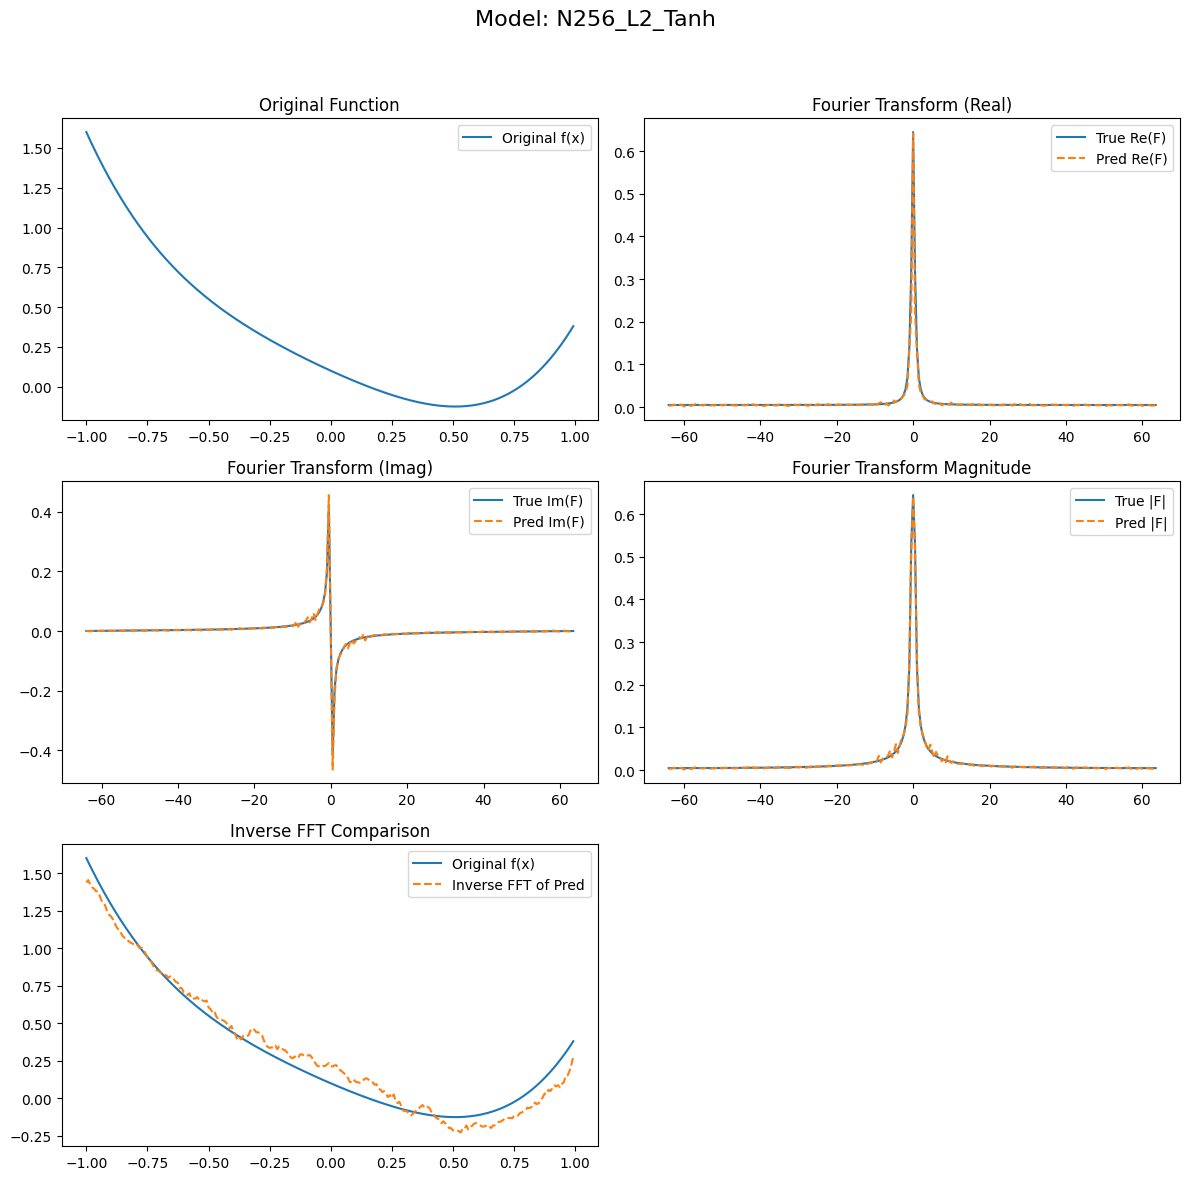

In [82]:
# test_functions = [
#     # Fourier: sum of sinusoids
#     lambda x: 1.3*np.sin(2*np.pi*2*x) + 0.9*np.sin(2*np.pi*4*x) + 1.7*np.sin(2*np.pi*5*x),

#     # Gaussian
#     lambda x: np.exp(-((x + 0.2)**2) / (2 * 0.15**2)),

#     # Polynomial (degree 3)
#     lambda x: 0.1 - 0.7*x + 0.3*x**2 + 0.1*x**3 + 0.6*x**4,

#     # Rectangular pulse
#     lambda x: ((x >= -0.3) & (x <= 0.1)).astype(float),

#     # Trig combo (sin + cos)
#     lambda x: 1.2*np.sin(2*np.pi*3*x) + 0.8*np.cos(2*np.pi*3*x)
# ]
import random

# ---- Choose model index ----
# Pick 0, 1, or 2 for top 3 models
model_idx = 0
test_loss, model_name, state_dict = top_models[0]

# ---- Pick a random test function ----
func = lambda x: 0.1 - 0.7*x + 0.3*x**2 + 0.1*x**3 + 0.6*x**4

# ---- Extract N, layers, activation from model_name ----
N = 256
layers = 2
activation = 'Tanh'

# ---- Prepare function and Fourier transform ----
x = np.linspace(-1, 1, N, endpoint=False)
dx = x[1] - x[0]
f = func(x).astype(np.float32)

# True FFT
F_true = np.fft.fft(f) * dx
F_true_shifted = np.fft.fftshift(F_true)
freqs = np.fft.fftfreq(N, d=dx)
freqs_shifted = np.fft.fftshift(freqs)

# Tensor input for model
f_tensor = torch.tensor(f, dtype=torch.float32, device=device).unsqueeze(0)

# ---- Initialize model and load weights ----
model = FourierNet(N=N, layers=layers, activation=activation).to(device)
model.load_state_dict(state_dict)
model.eval()

# ---- Predict FFT ----
with torch.no_grad():
    F_pred = model(f_tensor).cpu().numpy()[0]

F_pred_complex = F_pred[:,0] + 1j*F_pred[:,1]

# Inverse FFT
f_pred_ifft = np.fft.ifft(np.fft.ifftshift(F_pred_complex)) / dx

# ---- Plot ----
fig, axs = plt.subplots(3,2, figsize=(12,12))
fig.suptitle(f"Model: {model_name}", fontsize=16)

# Original function
axs[0,0].plot(x, f, label='Original f(x)')
axs[0,0].set_title("Original Function")
axs[0,0].legend()

# Fourier Transform: Real
axs[0,1].plot(freqs_shifted, F_true_shifted.real, label='True Re(F)')
axs[0,1].plot(freqs_shifted, F_pred_complex.real, '--', label='Pred Re(F)')
axs[0,1].set_title("Fourier Transform (Real)")
axs[0,1].legend()

# Fourier Transform: Imag
axs[1,0].plot(freqs_shifted, F_true_shifted.imag, label='True Im(F)')
axs[1,0].plot(freqs_shifted, F_pred_complex.imag, '--', label='Pred Im(F)')
axs[1,0].set_title("Fourier Transform (Imag)")
axs[1,0].legend()

# Fourier Transform: Magnitude
axs[1,1].plot(freqs_shifted, np.abs(F_true_shifted), label='True |F|')
axs[1,1].plot(freqs_shifted, np.abs(F_pred_complex), '--', label='Pred |F|')
axs[1,1].x_limit = (-10, 10)
axs[1,1].set_title("Fourier Transform Magnitude")
axs[1,1].legend()

# Inverse FFT comparison
axs[2,0].plot(x, f, label='Original f(x)')
axs[2,0].plot(x, f_pred_ifft.real, '--', label='Inverse FFT of Pred')
axs[2,0].set_title("Inverse FFT Comparison")
axs[2,0].legend()

# Hide empty subplot
axs[2,1].axis('off')

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [84]:
print(metrics["N256_L2_Tanh"]["Losses"])

[0.9882854838528583, 0.9921857471777298, 0.9967986395877091, 0.9566778482675238, 0.9854547400867382]


In [86]:
for r2, model_name, state_dict in top_models:
    print("Model Name:", model_name)
    print()
    torch.save(state_dict, f"{model_name}.pth")

import json

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

Model Name: N256_L2_Tanh

Model Name: N256_L3_Tanh

Model Name: N256_L4_Tanh



In [59]:
# Get (model_name, R²) pairs
r2_scores = [(name, vals["Test R2"]) for name, vals in metrics.items() if vals["Test R2"] is not None]

# Sort descending by R²
r2_scores.sort(key=lambda x: x[1], reverse=True)

# Print top 5
print("\nTop 5 models by R²:")
for i, (name, r2) in enumerate(r2_scores[:5], start=1):
    print(f"{i}. {name}: R² = {r2:.6f}")



Top 5 models by R²:
1. N256_L2_Tanh: R² = 0.619641
2. N256_L3_Tanh: R² = 0.536171
3. N512_L2_Tanh: R² = 0.468189
4. N256_L4_Tanh: R² = 0.466180
5. N512_L3_Tanh: R² = 0.448782
